In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Backpropagation with an Example

Example network:

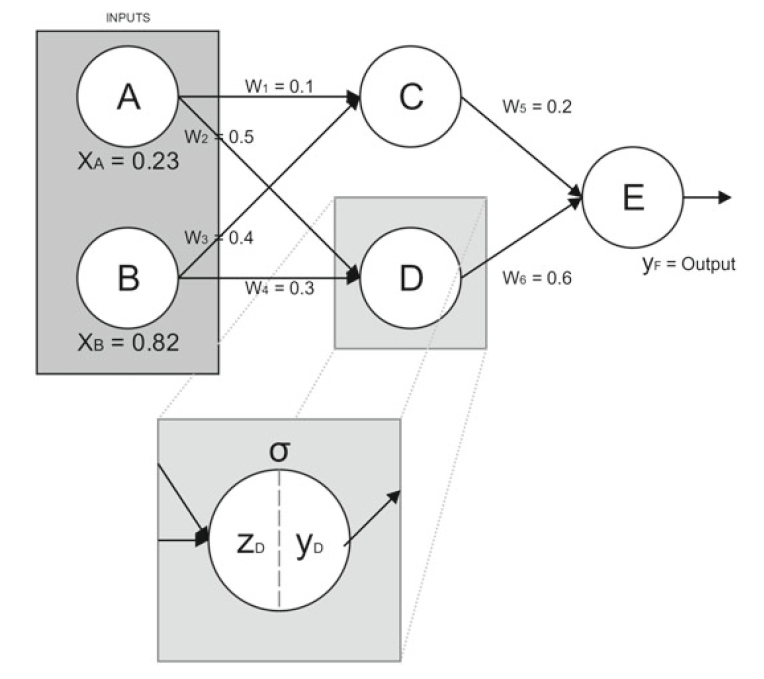

Activation function, Error and updates to weights:

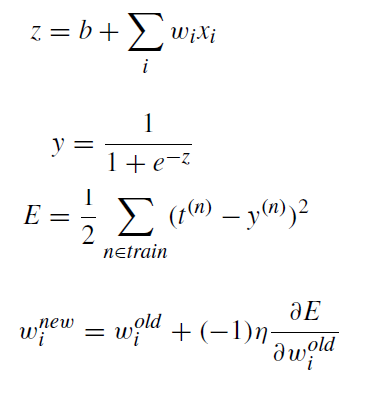

Let us start by deriving the value for dE

Motivation- To break down the differential equation using chain rule to obtain something resembling the following:

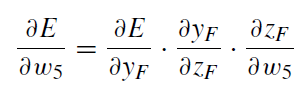

1. dy/dz:

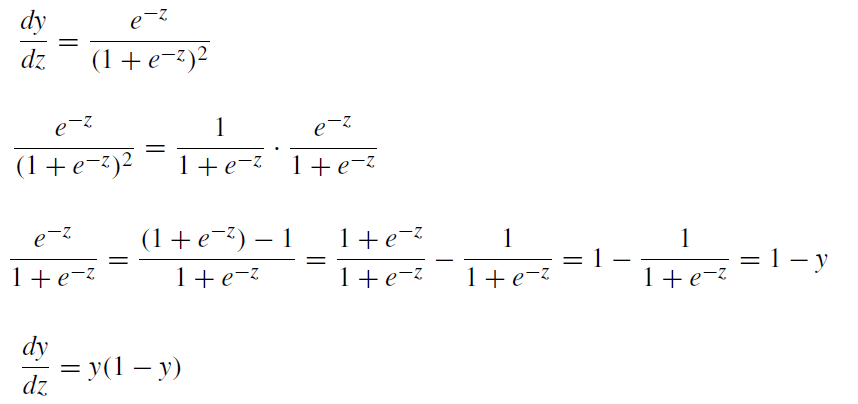

2. dE/dy:

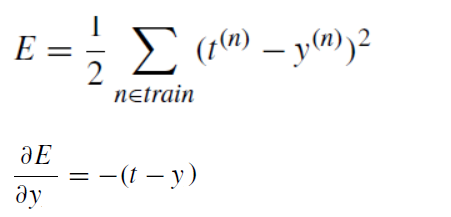

3. dz/dw:

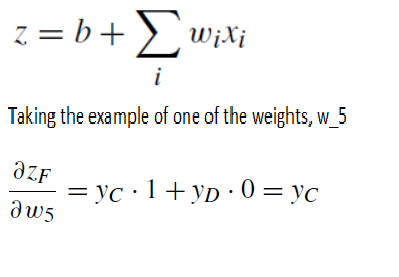

Now, taking the above example values, let's try and calculate the updated weight for w_5 after this iteration.

Refer to the network for the values.

First, computing Y_C and Y_D and using those to find Y_F:

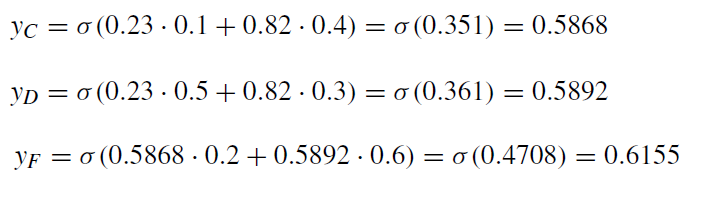

Now, to begin with our backprop, let's calculate the components of dE/dW.

The target t = 1 for our example.

First, finding dE/dY_F using the formula derived earlier:

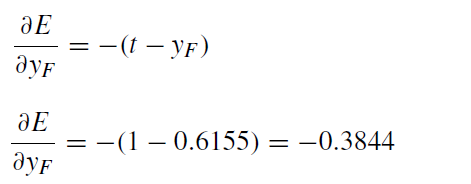

Next, dY_F/dZ_F:

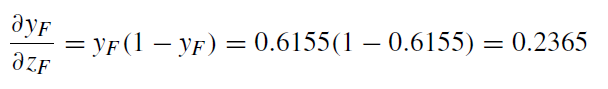

Finally dZ_F/dW_5:

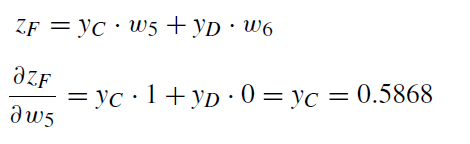

Now, plugging them all in:

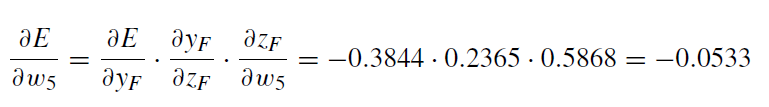

With that, we can calculate the updated weight for W_5 as follows:

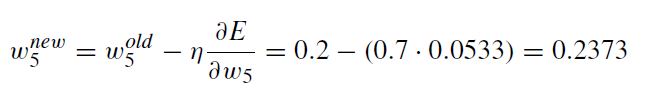


Similarly, you can try calculating the updated values for the remaining weights.

##Loss Functions

####Binary Cross Entropy:

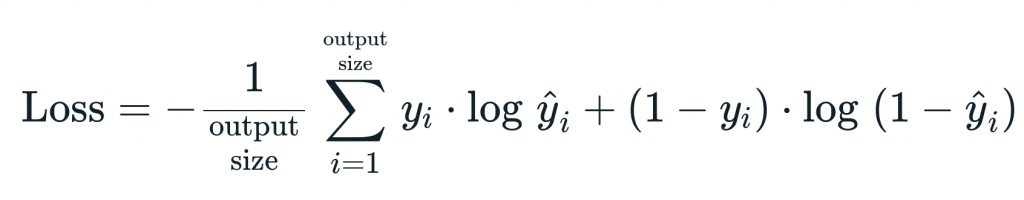
<br>
###Cross Entropy
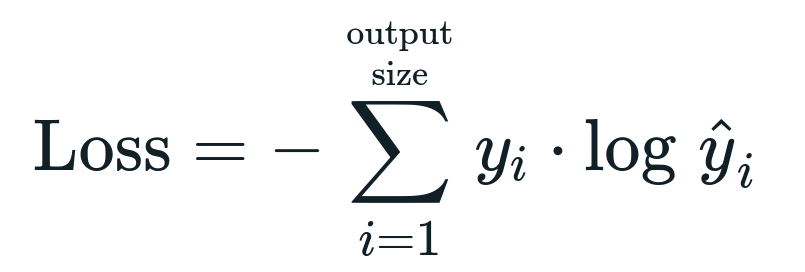


##Iterative MLP Calculation

In [2]:
class MLP:

  def __init__(self, input_size, layers, loss = 'cross_entropy'):
    self.n_features = input_size
    self.layer_info = layers
    self.loss = loss
    
    #Weights List
    self.weights = [np.random.randn(input_size, layers[0])]

    for i in range(len(layers)-1):
      self.weights.append(np.random.randn(layers[i], layers[i+1]))


    #Bias List
    self.bias = [np.random.randn(1, i) for i in layers]

    #Del terms for each layer
    self.delta = [np.zeros([1, i]) for i in layers]

    #Activated Output of Each Layer
    self.a = [np.zeros([1, input_size])]
    self.a.extend([np.zeros([1, i]) for i in layers])


  def forward_prop(self, features):

    self.a[0] = np.array(features).reshape(1, -1)

    #input to penultimate layer
    for i in range(len(self.weights)-1):
      for j in range(self.a[i+1].shape[1]):
        dot_sum = 0
        for k in range(self.a[i].shape[1]):
          dot_sum += self.a[i][0,k]*self.weights[i][k, j]
        self.a[i+1][0, j] = dot_sum + self.bias[i][0,j]
      self.a[i+1] = self.sigmoid(self.a[i+1])
  
    #final layer
    for j in range(self.a[-1].shape[1]):
      dot_sum = 0
      for k in range(self.a[-1].shape[1]):
        dot_sum += self.a[-2][0,k]*self.weights[-1][k, j]
      self.a[-1][0, j] = dot_sum + self.bias[-1][0,j]
    self.a[-1] = self.softmax(self.a[-1])

    return self.a[-1]


  def train(self, inputs, outputs, epochs = 10, learning_rate = 0.01):

    history = []
    for _ in range(epochs):
      cost = 0
      for i in range(inputs.shape[0]):
        cost += self.backprop(inputs[i], outputs[i], learning_rate)
      history.append(cost)
    
    return history


  def backprop(self, input, output, lr):

    y_hat = self.forward_prop(input)

    # Loss Propogation to softmax Layer
    if(self.loss == "SqE"):
      cost = self.SqE(output, y_hat)
      for i in range(self.delta[-1].shape[1]):
        self.delta[-1][0,i] = (y_hat[0,i] - output[i])  *  (self.a[-1][0,i]* (1 - self.a[-1][0,i]))
    else:
      cost = self.cross_entropy(output, y_hat)
      self.delta[-1] = self.a[-1] * np.sum(self.a[-1])  - output 

    # Backprop for n-1 sets of weights
    for i in range(len(self.weights)-1, 0, -1):
      # Delta for layer
      for j in range(self.delta[i-1].shape[1]):
        sum = 0
        for k in range(self.delta[i].shape[1]):
          sum += self.delta[i][0,k]*self.weights[i][j, k]
        self.delta[i-1][0,j] = sum*  (self.a[i][0,j] * (1 - self.a[i][0,j]))
      
      # Weight Update
      for j in range(self.weights[i].shape[0]):
        for k in range(self.weights[i].shape[1]):
          self.weights[i][j,k] -= lr*self.a[i][0,j]*self.delta[i][0, k]

      # Bias Update
      for j in range(self.bias[i].shape[1]):
        self.bias[i][0,j] -= lr*self.delta[i][0, j]

    # Last Layer of weights
    for j in range(self.weights[0].shape[0]):
        for k in range(self.weights[0].shape[1]):
          self.weights[0][j,k] -= lr*self.a[0][0,j]*self.delta[0][0, k]
    for j in range(self.bias[0].shape[1]):
        self.bias[0][0,j] -= lr*self.delta[0][0, j]

    return cost


  def sigmoid(self, input):
    x = np.zeros(input.shape)
    sum = 0;
    for i in range(x.shape[1]):
      x[0,i] = 1/(1+ np.exp(-1*input[0,i]))
    return x


  def predict(self, input):
    return np.argmax(self.forward_prop(input))


  def softmax(self, input):
    x = np.zeros(input.shape)
    sum = 0;
    for i in range(x.shape[1]):
      x[0,i] = np.exp(input[0,i])
      sum += x[0,i]

    for i in range(x.shape[1]):
      x[0,i] /= sum
    
    return x


  def SqE(self, y, y_hat):
    sum = 0
    for i in range(y_hat.shape[1]):
      sum += 0.5*(y[i] - y_hat[0,i])**2
    return sum


  def cross_entropy(self, y, y_hat):
    sum = 0
    for i in range(y_hat.shape[1]):
      sum += y[i] * np.log(y_hat[0,i])
    return -1*sum


In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

X = x_train.reshape(-1, 784)
Y = np.zeros([y_train.shape[0], 10])
X = tf.keras.utils.normalize(X, axis = 1)

for i in range(Y.shape[0]):
  Y[i][y_train[i]] = 1


11501568/11490434 [==============================] - 0s 0us/step


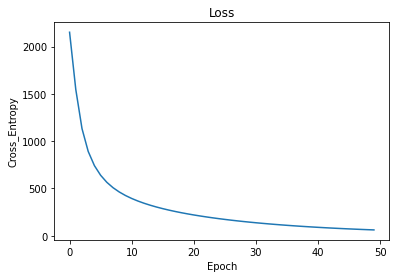

In [4]:
model = MLP(784, [16, 10], loss = 'cross_entropy')
h = model.train(X[:1000], Y[0:1000], 50, learning_rate=0.1)
plt.plot(h)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross_Entropy")
plt.show()

## Homework - Vectorized MLP Calculation
Complete the Class MLP_HW using vectorization and create and train an instance of it to fit a XOR gate logic<br>

Expected output: After every epoch print all weight updates in the format <br>
**"Layer i: <br>
Weights:  W_0_0 = 0.xx , W_0_1 = 0.xx ..... W_1_0 = 0.xx .....
<br>Deltas: del_0 = 0.xx ....... del_n"** <br>

In [ ]:
class MLP_HW:

  def __init__(self, input_size, layers):
    self.n_features = input_size
    self.layer_info = layers
    
    #Weights List
    self.weights = [np.random.randn(input_size, layers[0])]
    for i in range(len(layers)-1):
      self.weights.append(np.random.randn(layers[i], layers[i+1]))

    #Bias List
    self.bias = [np.random.randn(1, i) for i in layers]

    #Del terms for each layer
    self.delta = [np.zeros([1, i]) for i in layers]

    #Activated Output of Each Layer
    self.a = [np.zeros([1, input_size])]
    self.a.extend([np.zeros([1, i]) for i in layers])


  def forward_prop(self, features):

    self.a[0] = np.array(features).reshape(1, -1)

    for i in range(len(self.weights)-1):
      self.a[i+1] = np.dot(self.a[i], self.weights[i]) + self.bias[i]
      self.a[i+1] = self.sigmoid(self.a[i+1])
  
    self.a[-1] = np.dot(self.a[-2], self.weights[-1]) + self.bias[-1]
    self.a[-1] = self.sigmoid(self.a[-1])
    return self.a[-1]


  def train(self, inputs, outputs, epochs = 10, learning_rate = 0.01):

    history = []
    for j in range(epochs):
      cost = 0
      for i in range(inputs.shape[0]):
        cost += self.backprop(inputs[i], outputs[i], learning_rate)   

        ## Code here to print weights as specified earlier
        print("Layer ",i, ":")
        print("Weights: ",self.weights)
        print("Deltas: ",self.delta)
        print('')

      history.append(cost)
      print("Epoch ",j, ", cost: ",cost)
    return history


  def backprop(self, input, output, lr):

    y_hat = self.forward_prop(input) 

    cost = self.SqE(output, y_hat) 
    self.delta[-1] = self.a[-1] * np.sum(self.a[-1])  - output


    for i in range(len(self.weights)-1, 0, -1):
      self.delta[i-1] = np.dot(self.delta[i],self.weights[i].T)  *  (self.a[i] * (1 - self.a[i]))
      self.weights[i] -= lr*np.dot(self.a[i].T,self.delta[i])
      self.bias[i] -= lr*self.delta[i]

    self.weights[0] -= lr*np.dot(self.a[0].T,self.delta[0])
    self.bias[0] -= lr*self.delta[0]

    return cost


  def sigmoid(self, input):
    return 1 / (1 + np.exp(-input))


  def predict(self, input):
    out = self.forward_prop(input) > 0.5
    return out


  def SqE(self, y, y_hat):
    error = 0.5*np.sum((y-y_hat[0])**2)
    return error


In [ ]:
model = MLP_HW(2, [4, 1]) ## Model Architecture: 2 layers, with first hidden layer having 4 neurons and the output layer having 1 neuron (since sigmoid was used)

X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([0, 1, 1, 0])

In [ ]:
# Since SqE really sucks at learning, we have to train for lot of epochs and that too with a high learning rate
h = model.train(X, Y, epochs = 1000, learning_rate=0.5) 

Streaming output truncated to the last 5000 lines.
       [-3.62537   ],
       [ 9.26328372]])]
Deltas:  [array([[ 0.00172562,  0.00022367, -0.00199702,  0.00151379]]), array([[0.00225773]])]

Layer  1 :
Weights:  [array([[ 4.90831896,  0.19847278, -3.32487685, -6.6403051 ],
       [-6.50249179, -1.2605004 , -3.21948115,  5.15598225]]), array([[ 9.16236052],
       [ 0.54155693],
       [-3.62523233],
       [ 9.26577089]])]
Deltas:  [array([[-7.37341867e-06, -2.17797286e-04,  9.46498012e-04,
        -2.92475158e-03]]), array([[-0.00531148]])]

Layer  2 :
Weights:  [array([[ 4.90987868,  0.19876509, -3.32531115, -6.64030233],
       [-6.50249179, -1.2605004 , -3.21948115,  5.15598225]]), array([[ 9.16486031],
       [ 0.54230567],
       [-3.62510664],
       [ 9.26577119]])]
Deltas:  [array([[-3.11945655e-03, -5.84609811e-04,  8.68605925e-04,
        -5.53973693e-06]]), array([[-0.00536493]])]

Layer  3 :
Weights:  [array([[ 4.90896752,  0.19852183, -3.32527549, -6.64116966],
       

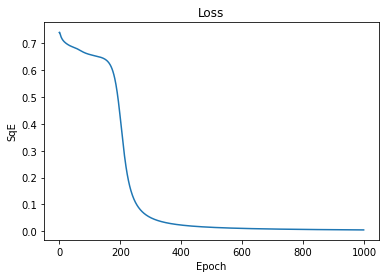

In [ ]:
plt.plot(h)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("SqE")
plt.show()

In [ ]:
a = model.predict([0,0])
b = model.predict([0,1])
c = model.predict([1,0])
d = model.predict([1,1])
print(a, ' ',b, ' ',c, ' ',d)

[[False]]   [[ True]]   [[ True]]   [[False]]
